# Feature Engineering

### Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

#Model Creation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

### Import data

In [2]:
final_df = pd.read_csv('data/final_df.csv',index_col = 0)

In [3]:
final_df.dtypes

Season                     int64
Week_Number                int64
Week_Name                 object
Baker                     object
Gender                    object
Age                        int64
Signature_Handshake        int64
Technical_Rank             int64
Showstopper_Handshake      int64
Favorite                 float64
Least_Favorite             int64
Star_Baker                 int64
Eliminated                 int64
Winner                     int64
signature                 object
showstopper               object
dtype: object

### Create a table of winners for future reference

In [4]:
Table_of_Winners = final_df.loc[final_df.Winner == 1]

In [5]:
Table_of_Winners = Table_of_Winners[['Season','Baker']].drop_duplicates()

In [6]:
Table_of_Winners.to_csv('data/Table_of_Winners.csv')

After understanding my data better:
- It seems the winner decided by whoever wins the final star baker. Therefore I will remove Winner from my dataset and set the target feature to Star Baker.
- Week_Name is redundant with Week_Number. I'll remove Week_Number
- We don't need the names of the bakers.
- Lastly, we will remove the name of the season, because older seasons won't show up in future datasets

### Drop Week_Number, Baker, Winner

In [7]:
df = final_df.drop(columns=['Week_Number','Baker','Winner','Season'])

In [8]:
df = df.astype({'Week_Name':'category',
                       'Gender':'category'})
df.dtypes

Week_Name                category
Gender                   category
Age                         int64
Signature_Handshake         int64
Technical_Rank              int64
Showstopper_Handshake       int64
Favorite                  float64
Least_Favorite              int64
Star_Baker                  int64
Eliminated                  int64
signature                  object
showstopper                object
dtype: object

In [101]:
df.head()

,Week_Name,Gender,Age,Signature_Handshake,Technical_Rank,Showstopper_Handshake,Favorite,Least_Favorite,Star_Baker,Eliminated,signature,showstopper
0,Cake,M,31,0,2,0,0.0,0,0,0,Rhubarb and Custard CupcakesAfter Dinner Cupcakes,Vanilla Sponge with White Chocolate and Raspbe...
1,Cake,F,31,0,1,0,0.0,0,1,0,Cherry Bakewell Inspired CupcakesGinger Cupcak...,Novelty Farm Cake
2,Cake,M,40,0,10,0,0.0,0,0,0,Apple and Cinnamon Cupcakes,Unknown
3,Cake,F,63,0,8,0,0.0,0,0,0,Raspberry and Cream Cupcakes,Chocolate Marble Cakewith Dark and White Choco...
4,Cake,M,19,0,6,0,0.0,0,0,0,Lemon Meringue CupcakesApple and Cinnamon Cupc...,Unknown


### Get my split ready

In [10]:
X = df.drop(columns='Star_Baker')
y= df['Star_Baker'].values

In [11]:
#is our class unbalanced?
#we should use SMOTE for class balance
df.Star_Baker.value_counts()

0    576
1     88
Name: Star_Baker, dtype: int64

In [100]:
#test_size of 30%.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=0,stratify = y)

#create unique lists for our different transformed columns
num_cols = list(X_train.select_dtypes(include='number').columns)
cat_cols = list(X_train.select_dtypes(include='category').columns)
sig_text = ('signature')
show_text = ('showstopper')

#add the transformers
preprocessor = ColumnTransformer( 
    transformers = [
        
        ('num',StandardScaler(),num_cols),                         #scale the numerical values
        ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols), #encode the categorical features
        ('text_sig',TfidfVectorizer(max_features=50),sig_text),    #freq counts for words
        ('text_show',TfidfVectorizer(max_features=50),show_text)   #freq counts for words
    ], remainder='passthrough')


#initialize the SMOTE class
smt = SMOTE(random_state=0)

pipeline = Pipeline( #using imblearn.pipeline
    [('preprocess',preprocessor),
     ('smote',smt),
     ('RandomForestClassifier',RandomForestClassifier(n_estimators = 300, random_state = 1, n_jobs=-1))
    ]
)


X_train_trans = pipeline.fit(X_train,y_train)
ypred=pipeline.predict(X_test)

print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        31
           1       1.00      0.33      0.50         6

    accuracy                           0.89        37
   macro avg       0.94      0.67      0.72        37
weighted avg       0.90      0.89      0.87        37



In [59]:
#View our transformed X_train_trans
pd.DataFrame(X_train_trans.toarray(),columns=preprocessor.get_feature_names_out())

,num__Age,num__Signature_Handshake,num__Technical_Rank,num__Showstopper_Handshake,num__Favorite,num__Least_Favorite,num__Eliminated,cat__Gender_F,cat__Gender_M,text_sig__almond,...,text_show__salted,text_show__sarawak,text_show__savoy,text_show__sfogliatelle,text_show__spiced,text_show__style,text_show__the,text_show__torte,text_show__white,text_show__with
0,-0.306059,3.359422,1.774428,-0.154303,-0.750757,-0.828417,-0.421998,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.287649,-0.297670,-0.902779,-0.154303,1.331989,-0.828417,-0.421998,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.386600,-0.297670,1.328227,-0.154303,-0.750757,1.207122,2.369680,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.207107,-0.297670,-1.348980,-0.154303,1.331989,-0.828417,-0.421998,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.405010,-0.297670,-0.456578,-0.154303,-0.750757,1.207122,-0.421998,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.782406,-0.297670,0.882026,-0.154303,-0.750757,1.207122,-0.421998,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,-0.405010,-0.297670,0.882026,-0.154303,1.331989,-0.828417,-0.421998,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.683454,-0.297670,2.220629,-0.154303,-0.750757,-0.828417,-0.421998,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,-0.405010,-0.297670,-0.902779,-0.154303,1.331989,-0.828417,-0.421998,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Creation

### RandomForest

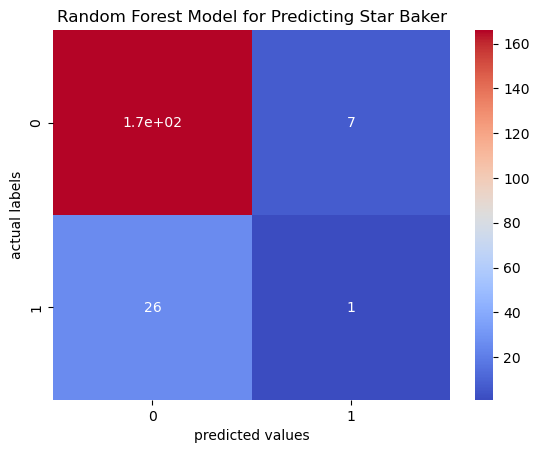

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       173
           1       0.12      0.04      0.06        27

    accuracy                           0.83       200
   macro avg       0.49      0.50      0.48       200
weighted avg       0.76      0.83      0.79       200

The training score for the random forest model is 1.0     
and the testing score for the model is 0.835


In [17]:
#RandomForest without CV/SMOTE
from sklearn.metrics import precision_score

rf = RandomForestClassifier(n_estimators = 300, random_state = 1, n_jobs=-1)



#fit
model =rf.fit(X_train_trans,y_train)

#pred
y_pred = model.predict(X_test_trans)

#confusion matrix
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm,annot=True,cmap='coolwarm')
plt.xlabel('predicted values')
plt.ylabel('actual labels')
plt.title('Random Forest Model for Predicting Star Baker')
plt.show()

print(classification_report(y_test,y_pred))

#scores

training_score = (rf.score(X_train_trans,y_train))
testing_score = (rf.score(X_test_trans, y_test))

print(f'The training score for the random forest model is {training_score}\
     \nand the testing score for the model is {testing_score}')

precision is terrible. Lets use SMOTE To clean up class imbalance

### Creating a table to store model outputs

In [18]:
Model_Data_Frame = pd.DataFrame({"Random Forest w/o CV": [training_score,testing_score]})
index_name = ['Training','Testing']
Model_Data_Frame.index=index_name
Model_Data_Frame

,Random Forest w/o CV
Training,1.000
Testing,0.835


In [19]:
#SMOTE

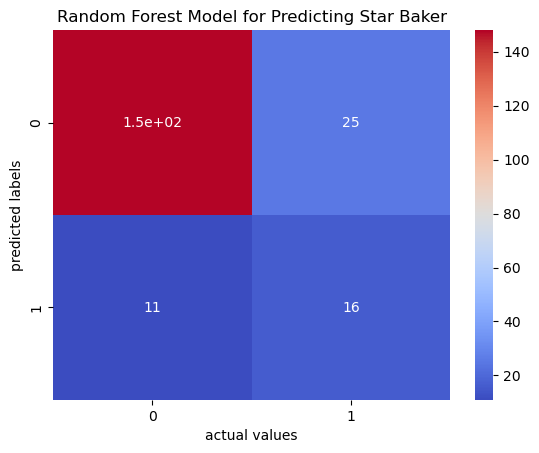

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       173
           1       0.39      0.59      0.47        27

    accuracy                           0.82       200
   macro avg       0.66      0.72      0.68       200
weighted avg       0.86      0.82      0.83       200

The training score for the random forest model is 0.9461206896551724     
and the testing score for the model is 0.82


In [20]:
#RandomForest with GS/SMOTE & CV
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state = 1, n_jobs=-1)


model = Pipeline(steps=[
    ('sampling',SMOTE(random_state=1)),
    ('classifier',rf)
])

grid_params={'classifier__n_estimators':np.arange(300,325),
             'classifier__max_depth':np.arange(2,11)}

modelCV = GridSearchCV(model,grid_params,cv=4)

modelCV.fit(X_train_trans,y_train)

y_pred = modelCV.predict(X_test_trans)

#confusion matrix
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm,annot=True,cmap='coolwarm')
plt.xlabel('actual values')
plt.ylabel('predicted labels')
plt.title('Random Forest Model for Predicting Star Baker')
plt.show()

print(classification_report(y_test,y_pred))

#scores

training_score = (modelCV.score(X_train_trans,y_train))
testing_score = (modelCV.score(X_test_trans, y_test))

print(f'The training score for the random forest model is {training_score}\
     \nand the testing score for the model is {testing_score}')

### Creating a table to store model outputs

In [21]:
Model_Data_Frame = pd.DataFrame({"Random Forest w/o CV": [training_score,testing_score]})
index_name = ['Training','Testing']
Model_Data_Frame.index=index_name
Model_Data_Frame

,Random Forest w/o CV
Training,0.946121
Testing,0.820000


### Logistic Regression

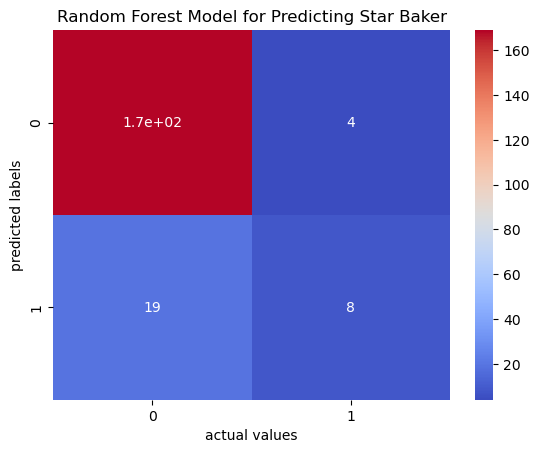

In [22]:

#is this the right solver / max_iter?
logreg = LogisticRegression()
param_grid = {'C':np.arange(.1,1.1,.1)}

logreg_cv =GridSearchCV(logreg,param_grid,cv=5)


logreg_cv.fit(X_train_trans,y_train)
y_pred_logreg = logreg_cv.predict(X_test_trans)

#confusion matrix
cm = confusion_matrix(y_test,y_pred_logreg)

sns.heatmap(cm,annot=True,cmap='coolwarm')
plt.xlabel('actual values')
plt.ylabel('predicted labels')
plt.title('Random Forest Model for Predicting Star Baker')
plt.show()

In [23]:
print(classification_report(y_test,y_pred_logreg))

#scores

training_score = (logreg_cv.score(X_train_trans,y_train))
testing_score = (logreg_cv.score(X_test_trans, y_test))

print(f'The training score for the Logistic Regression model is {training_score}\
     \nand the testing score for the model is {testing_score}\
     /nand the best params for C for the model is {logreg_cv.best_params_}')

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       173
           1       0.67      0.30      0.41        27

    accuracy                           0.89       200
   macro avg       0.78      0.64      0.67       200
weighted avg       0.87      0.89      0.87       200

The training score for the Logistic Regression model is 0.8879310344827587     
and the testing score for the model is 0.885     /nand the best params for C for the model is {'C': 0.1}


In [24]:
Model_Data_Frame['Logistic Regression']=[training_score,testing_score]
Model_Data_Frame

,Random Forest w/o CV,Logistic Regression
Training,0.946121,0.887931
Testing,0.820000,0.885000


In [25]:
#pd.DataFrame(zip(range(1,len(logreg_cv.best_estimator_.coef_[0])),logreg_cv.best_estimator_.coef_[0]))
Coef_Table = pd.DataFrame(zip(preprocessor.get_feature_names_out(),logreg_cv.best_estimator_.coef_[0])).sort_values(1,ascending=False)
Coef_Table.columns=['feature','coef']
Coef_Table.head(10)

,feature,coef
4,num__Favorite,0.786750
21,cat__Week_Name_Final,0.396953
1,num__Signature_Handshake,0.258724
137,text_show__white,0.116237
67,text_sig__orange,0.105550
103,text_show__coconut,0.100277
49,text_sig__caramel,0.098755
71,text_sig__pies,0.087489
91,text_show__apple,0.087185
40,text_sig__and,0.077924


In [26]:
# you can see that being labeled as "favorite" heading into the showstopper challenge is very important!

## Logistic model with lasso regression

In [27]:
#is this the right solver / max_iter?
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear')
param_grid = {'C':np.arange(.1,1.1,.1)}

logreg_cv =GridSearchCV(logreg_lasso,param_grid,cv=5)


logreg_cv.fit(X_train_trans,y_train)

Coef_Table = pd.DataFrame(zip(preprocessor.get_feature_names_out(),
                              logreg_cv.best_estimator_.coef_[0])).sort_values(1,ascending=False)
Coef_Table.columns=['feature','coef']
Coef_Table[Coef_Table.coef!=0].reset_index(drop=True)

,feature,coef
0,cat__Week_Name_Final,2.725398
1,num__Favorite,0.973669
2,num__Signature_Handshake,0.275086
3,num__Showstopper_Handshake,0.026716
4,num__Age,-0.064467
5,cat__Gender_M,-0.069042
6,text_show__pie,-0.254305
7,text_sig__black,-0.437709
8,num__Least_Favorite,-0.571158
9,num__Technical_Rank,-1.024087


You can see when we use a lasso regression, that making it to the finals is the most important factor for winning star baker

### logistic regression with squential feature selection

In [28]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1=SFS(logreg_cv,
        k_features=(1,10),
        forward=True,
        floating=False,
        verbose=0,
        scoring='accuracy',
        cv=5,
        n_jobs=-1)
sfs1=sfs1.fit(X_train_trans,y_train)

In [29]:
#List of most important features
list(preprocessor.get_feature_names_out()[list(sfs1.k_feature_idx_)])

['num__Age',
 'num__Signature_Handshake',
 'num__Showstopper_Handshake',
 'num__Least_Favorite',
 'num__Eliminated',
 'cat__Week_Name_Final',
 'text_show__white']

In [30]:
X_train_trans_sel = sfs1.transform(X_train_trans)
X_test_trans_sel  = sfs1.transform(X_test_trans)
X_train_trans_sel.shape

(464, 7)

In [31]:
#fit the model
logreg_cv.fit(X_train_trans_sel,y_train)

training_score = (logreg_cv.score(X_train_trans_sel,y_train))
testing_score = (logreg_cv.score(X_test_trans_sel, y_test))
print(training_score)
print(testing_score)

0.8814655172413793
0.875


In [32]:
Model_Data_Frame['Logistic Regression with SFS']=[training_score,testing_score]
Model_Data_Frame

,Random Forest w/o CV,Logistic Regression,Logistic Regression with SFS
Training,0.946121,0.887931,0.881466
Testing,0.820000,0.885000,0.875000


### Gradient Boosting

In [33]:
learning_rate = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
n_estimators = [18,19,20,21,22]
max_depth = [1,2,3]
params = ({'learning_rate': learning_rate,
          'n_estimators' : n_estimators,
          'max_depth': max_depth})


In [34]:
gb = GradientBoostingClassifier()
cv = GridSearchCV(gb,params, cv=5)
cv.fit(X_train_trans,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
                         'max_depth': [1, 2, 3],
                         'n_estimators': [18, 19, 20, 21, 22]})

In [35]:
training =cv.score(X_train_trans, y_train)
testing =cv.score(X_test_trans, y_test)

print("Accuracy score (training): {0:.3f}".format(training))
print("Accuracy score (validation): {0:.3f}".format(testing))


Accuracy score (training): 0.881
Accuracy score (validation): 0.860


In [36]:
Model_Data_Frame['Gradient Boosting (w/CV)']=[training,testing]

### KNN

In [37]:

simplefilter(action='ignore', category=FutureWarning) # to deal with annoying future warning
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train_trans,y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [38]:
knn_cv.best_params_

{'n_neighbors': 42}

In [39]:
training =knn_cv.score(X_train_trans, y_train)
testing =knn_cv.score(X_test_trans, y_test)

print("Accuracy score (training): {0:.3f}".format(training))
print("Accuracy score (validation): {0:.3f}".format(testing))


Accuracy score (training): 0.866
Accuracy score (validation): 0.865


In [40]:
Model_Data_Frame['KNN (w/CV)']=[training,testing]

In [41]:
Model_Data_Frame

,Random Forest w/o CV,Logistic Regression,Logistic Regression with SFS,Gradient Boosting (w/CV),KNN (w/CV)
Training,0.946121,0.887931,0.881466,0.881466,0.866379
Testing,0.820000,0.885000,0.875000,0.860000,0.865000


# Train Test Split for Each Week

I want to run a logistic regression model for each week to find if feature importance differs for the various challenges. Unfortuantly, certain weeks, such as vegan week, has only occured 1 time with a whooping total of 5 rows of data and only 1 instance of a Star_Baker... not enough for methods such as SMOTE to deal with class imbalance. Since we need atleast two instances of Star_Baker for a working model, I'll combine the "unique" week themes into a category of "Other Themes"

In [42]:
Theme_Split_DF=df
Other_Themes = list(final_df.Week_Name[final_df.groupby("Week_Name")['Season'].transform('nunique')<2].unique())
Other_Themes


['Unconventional',
 'European Cakes',
 'Advanced Dough',
 'Alternative',
 'Victorian',
 'Chocolate',
 'Batter',
 'Botanical',
 'Tudor',
 'Caramel',
 'Italian',
 'Forgotten',
 'Spice',
 'Vegan',
 'Danish',
 'Dairy',
 'Roaring Twenties',
 'Festivals']

In [43]:
# need to convert away from categorical feature to use the code below and change those values to "other theme"
Theme_Split_DF.Week_Name=Theme_Split_DF.Week_Name.astype('string')

In [44]:
Theme_Split_DF.loc[Theme_Split_DF.Week_Name.isin(Other_Themes),'Week_Name']= 'Other Themes'

In [45]:
list(Theme_Split_DF.Week_Name.unique())

['Cake',
 'Tarts',
 'Bread',
 'Biscuits',
 'Pie',
 'Dessert',
 'Pâtisserie',
 'Final',
 'Pudding',
 'Sweet Dough',
 'Pie and Tart',
 'Pastry',
 'Other Themes']

In [46]:
df_append_list=[]
week_important_features=pd.DataFrame()


for week in Theme_Split_DF.Week_Name.unique():#Look over the unique Week_Names (aka baking themes)
    
    df_subset = df[df.Week_Name== week] #create df subsets
    
    X= df_subset.drop(columns=['Week_Name','Star_Baker']) 
    y= df_subset['Star_Baker'].values
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=0,stratify = y)
   
    #create unique lists for our different transformed columns
    num_cols = list(X_train.select_dtypes(include='number').columns)
    cat_cols = list(X_train.select_dtypes(include='category').columns)
    sig_text = ('signature')
    show_text = ('showstopper')

    #add the transformers to preprocessor
    preprocessor = ColumnTransformer( 
        transformers = [
            ('num',StandardScaler(),num_cols),
            ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols),
            ('text_sig',TfidfVectorizer(max_features=50),sig_text),
            ('text_show',TfidfVectorizer(max_features=50),show_text)
        ], remainder='passthrough')


    #Fit and Transform our Training and Testing Data
    X_train_trans = preprocessor.fit_transform(X_train)
    X_test_trans  = preprocessor.transform(X_test)
    
    # create our logit model
    model =  LogisticRegression(penalty='l1', solver='liblinear', random_state=0)

    
    
     #DOES NOT WORK 
    #######################
    #Initialize and fit/resample our data with SMOTE
    #sm = SMOTE()
    #X_train_trans_re, y_train_re = sm.fit_resample(X_train_trans,y_train)
    #####################
    
    
    # fit our model
    model.fit(X_train_trans, y_train)
    
    #pull our coefs and feature names
    modeldf = pd.DataFrame(preprocessor.get_feature_names_out(),model.coef_[0]).reset_index().rename(columns={'index':'Coef',0:'Feature'})
    modeldf = modeldf[modeldf.Coef!=0].sort_values('Coef', ascending = False)
    modeldf['Week']= week
    
    #append to our list
    df_append_list.append(modeldf)
    
    y_pred = model.predict(X_test_trans)
    
    print(week)
    print(classification_report(y_test,y_pred))
    print("--------")
    
#create a df from our list of dfs
week_important_features=pd.concat(df_append_list)

#reorder columns
week_important_features=week_important_features[['Week','Feature','Coef']].sort_values('Week')
week_important_features


Cake
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.50      0.33      0.40         3

    accuracy                           0.91        33
   macro avg       0.72      0.65      0.68        33
weighted avg       0.90      0.91      0.90        33

--------
Tarts
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.00      0.00      0.00         1

    accuracy                           0.86         7
   macro avg       0.43      0.50      0.46         7
weighted avg       0.73      0.86      0.79         7

--------
Bread
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.00      0.00      0.00         3

    accuracy                           0.83        29
   macro avg       0.44      0.46      0.45        29
weighted avg       0.80      0.83      

/Users/matt/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matt/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matt/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matt/opt/anacon

Pie and Tart
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5

--------
Pastry
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.00      0.00      0.00         2

    accuracy                           0.77        13
   macro avg       0.42      0.45      0.43        13
weighted avg       0.71      0.77      0.74        13

--------
Other Themes
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        31
           1       1.00      0.33      0.50         6

    accuracy                           0.89        37
   macro avg       0.94      0.67      0.72        37
weighted avg       0.90

,Week,Feature,Coef
2,Biscuits,num__Technical_Rank,-0.315327
7,Biscuits,cat__Gender_F,-0.007093
4,Biscuits,num__Favorite,0.810928
0,Biscuits,num__Age,-0.694617
1,Bread,num__Signature_Handshake,0.144850
7,Bread,cat__Gender_F,-0.906982
2,Bread,num__Technical_Rank,-0.171887
0,Bread,num__Age,-0.093301
4,Bread,num__Favorite,1.219107
4,Cake,num__Favorite,1.172213
